In [ ]:
!pip install azure-storage-blob

In [18]:
from azure.storage.blob import BlobServiceClient

connection_string = "DefaultEndpointsProtocol=https;AccountName=storagelucasv;AccountKey=nfshKMTaX1gRybJy+o4SYnrrqJJYAm5ooBwUKaZi7cm0V8PG4w7pQrn40O2qlRGhbJiH2iahS6sm+AStAJFMTA==;EndpointSuffix=core.windows.net"
container_name='testcontainer'

blob_service_client= BlobServiceClient.from_connection_string(connection_string)
blob_client_orders = blob_service_client.get_blob_client(container_name,'Samarra/orders.csv')
blob_client_order_events = blob_service_client.get_blob_client(container_name,'Samarra/order_events.csv')
blob_client_payments = blob_service_client.get_blob_client(container_name,'Samarra/payments.csv')

blob_data_orders = blob_client_orders.download_blob()
blob_data_order_events = blob_client_order_events.download_blob()
blob_data_payments = blob_client_payments.download_blob()

orders_data = blob_data_orders.content_as_text()
order_events_data = blob_data_order_events.content_as_text()
payments_data = blob_data_payments.content_as_text()

In [19]:
import io
import pandas as pd
## importing datasets
orders = pd.read_csv(io.StringIO(orders_data), index_col='id_order', parse_dates=['created_at'])
order_events = pd.read_csv(io.StringIO(order_events_data), index_col='event_id', parse_dates=['created_at'])
payments = pd.read_csv(io.StringIO(payments_data), index_col='id_payment', parse_dates=['due_date', 'paid_date', 'last_late_fee_recorded_at', 'created_at', 'updated_at'])

In [20]:
## 1) IMPORTING MODULES
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
## 2) EXPLORING THE DATASETS AND IMPROTING DATASETS BASED ON MY FINDINGS

In [ ]:
# A) ORDERS
print(f"ORDERS -> SHAPE: {orders.shape}, COLUMNS: {orders.columns}")

In [ ]:
# B) ORDER_EVENTS
## dropping "id" column as it's redundant
order_events.drop('id', axis=1, inplace=True)
## exploring the result
print(f"ORDER_EVENTS -> SHAPE: {order_events.shape}, COLUMNS: {order_events.columns}")

In [ ]:
# C) PAYMENTS
print(f"PAYMENTS -> SHAPE: {payments.shape}, COLUMNS: {payments.columns}")

In [ ]:
## 3) DATA CLEANING

In [ ]:
## ORDER_EVENTS DATAFRAME NEEDS FURTHER MANIPULATION. FIRST EXPLORING THE COLUMNS I NEED TO CHANGE AND THEN APPLYING THE NECESSARY CHANGES TO THEM.

## I'm only interested in the last part of the string, where the reason is displayed.
print(order_events['event_name'][0])

In [ ]:
## cleaning event_name column to display only Declined or Authorized
order_events['event_name'] = order_events['event_name'].apply(lambda x: x.split('OrderWas')[-1])
order_events['event_name']

In [ ]:
## 4) Calculating 2 Key Metrics: Delincuency Rate and Recovery Rate
## First I need to join the orders table with the payments.
orders_payments = payments.merge(orders, left_on='order_id', right_on='id_order', how='left')


In [ ]:
## Delincuency Rate = (number of paid late payments + number of unpaid late payments)/number of total payments

## number of paid late payments
paid_late_payments = len(orders_payments[(orders_payments['status_x'] == 'paid') & (orders_payments['payment_type_y'] == 'PAY_BY_LATER')])

## number of unpaid late payments
unpaid_late_payments = len(orders_payments[(orders_payments['status_x'] == 'pending') & (orders_payments['payment_type_y'] == 'PAY_BY_LATER')])

## number of total payments
total_payments = len(orders_payments)

In [ ]:
# DELINCUNECY RATE
delincuency_rate = (paid_late_payments + unpaid_late_payments)/total_payments
delincuency_rate

In [ ]:
## Recovery Rate = # of paid late payments / (# paid late payments + # of unpaid late payments)
recovery_rate = paid_late_payments/(paid_late_payments + unpaid_late_payments)
recovery_rate

In [ ]:
# 5)
# We observe a large volume of expired orders, but they are multiple attempts of the same order. 
# Find the number of unique orders that were unsuccessful due to expiry, and were not eventually successful.

# Creates two tables: one for expired orders and another one for non-expired orders. Getting only the customer_id as each order is unique regardless of the multiple attempts
not_expired_orders = orders.query('status != "expired"')['customer_id']
expired_orders = orders.query('status == "expired"')['customer_id']

## I need customers that are in the expired table but are not in the not_expired table
num_of_unique_ord =  len(expired_orders) - len(expired_orders[expired_orders.isin(not_expired_orders)])
num_of_unique_ord

In [ ]:
# 6)
## There are orders where the 3rd installment was paid before the 2nd, 
# causing the affected customers to be charged late fees even though they technically made a payment to Samarra before the due date of the 2nd installment. 
# Identify these orders. Down payments should not be included in this calculation.

## filters the data with the necessary conditions and stores it in a new variable
orders_with_faulty_fee = payments.query('payment_type == 2 & late_fee_amount != 0 & late_fee_amount != 0 & paid_date < due_date')['order_id']
orders_with_faulty_fee

In [ ]:
## 7) What are the top reasons for orders being declined?

# As we may need data from the payload, I created a separate column with declined reason and appended it to the DataFrame
order_events['declined_reason'] = [reason.split('": "')[-1].split('"')[0] for reason in order_events['payload']]

## making a value count for each declined reason
top_declined_reasons = order_events['declined_reason'].value_counts().head(6)
top_declined_reasons

In [ ]:
#### DATA VISUALIZATION

<BarContainer object of 16 artists>

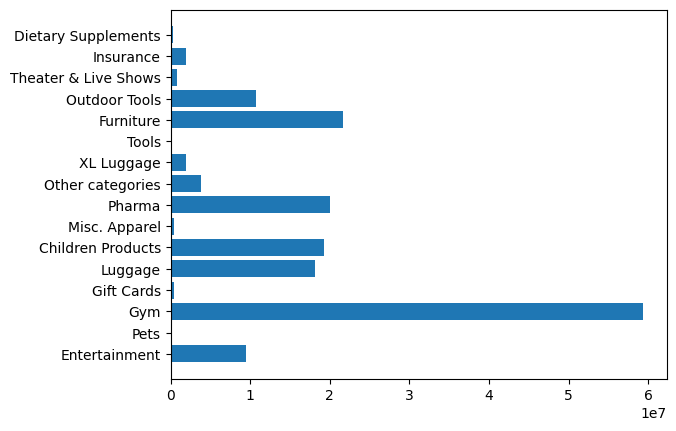

In [21]:
# TOP SALES BY CATEGORY

# create the two measures needed to plot.
total_sum_by_category = orders.groupby(['merchant_category'])['paid_amount'].sum()
categories = orders['merchant_category'].unique()

# creates an horizontal bar chart
plt.barh(categories, total_sum_by_category)


(array([18597., 18611., 18628., 18642., 18659., 18673., 18687., 18701.,
        18718.]),
 [Text(18597.0, 0, '2020-12-01'),
  Text(18611.0, 0, '2020-12-15'),
  Text(18628.0, 0, '2021-01-01'),
  Text(18642.0, 0, '2021-01-15'),
  Text(18659.0, 0, '2021-02-01'),
  Text(18673.0, 0, '2021-02-15'),
  Text(18687.0, 0, '2021-03-01'),
  Text(18701.0, 0, '2021-03-15'),
  Text(18718.0, 0, '2021-04-01')])

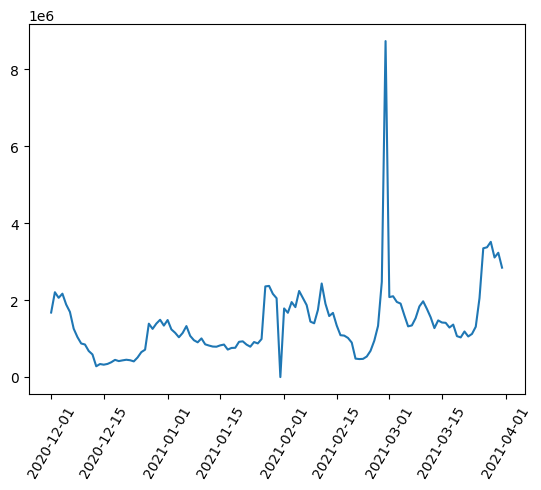

In [22]:
## TIMESERIES FOR ORDERS

# sets a index to a timeseries column to use resample()
orders.set_index(orders['created_at'], inplace=True)

## creates a variable with the total paid amount groupped by day
total_by_month = orders['paid_amount'].resample("D").sum()

## plots
plt.plot(total_by_month)
plt.xticks(rotation=60)


In [ ]:
!pip install pyodbc


In [10]:
## CONNECT TO A AZURE SQL DATABASE

import pyodbc           ## importing pyodbc library to work with pyodbc class
import pandas as pd
from getpass import getpass

## Azure SQL DB credentials
server = 'lvtestserver.database.windows.net'
database = 'lucasvdb'
username = 'lucasvitantonio'
password = getpass()    # creates an input when executing the code to type in the pass
driver= '{ODBC Driver 18 for SQL Server}'
connection_string= 'Driver='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password

## creates an connection with connect() method (instance of pyodbc class)
cn = pyodbc.connect(connection_string)

## store the query into query variable
query = "SELECT productID, Name, ListPrice, SellStartDate FROM SalesLT.Product WHERE ListPrice > (SELECT AVG(ListPrice) FROM SalesLT.Product) ORDER BY ListPrice DESC"

## creating cursor and executing query inside the with statement allows 
## me to run queries with the same connection without having to close the conn.
with cn:
    # creates a cursor to work with
    cursor  = cn.cursor()
    # executes query
    cursor.execute(query)

    
# creates and stores the query into a table called 'table'
top_products = pd.read_sql(query, cn)    ## read_sql() takes 2 param, the query string and the connection instance

## closes connection with the database after using it
cn.close()

## checks new table
print(top_products)
top_products.info()


C:\Users\Lucas\AppData\Local\Temp\ipykernel_6208\2021010201.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top_products = pd.read_sql(query, cn)    ## read_sql() takes 2 param, the query string and the connection instance


     productID                       Name  ListPrice SellStartDate
0          749           Road-150 Red, 62    3578.27    2005-07-01
1          750           Road-150 Red, 44    3578.27    2005-07-01
2          751           Road-150 Red, 48    3578.27    2005-07-01
3          752           Road-150 Red, 52    3578.27    2005-07-01
4          753           Road-150 Red, 56    3578.27    2005-07-01
..         ...                        ...        ...           ...
97         770         Road-650 Black, 52     782.99    2005-07-01
98         980  Mountain-400-W Silver, 38     769.49    2007-07-01
99         981  Mountain-400-W Silver, 40     769.49    2007-07-01
100        982  Mountain-400-W Silver, 42     769.49    2007-07-01
101        983  Mountain-400-W Silver, 46     769.49    2007-07-01

[102 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------      

In [ ]:
## PUSHING THE NEW TABLE INTO THE CLOUD STORAGE AS BLOB

## importing modules
from azure.storage.blob import BlobServiceClient

## parsing table to CSV file type
top_products_csv = top_products.to_csv(index=False)

## credentials
connection_string = "DefaultEndpointsProtocol=https;AccountName=storagelucasv;AccountKey=nfshKMTaX1gRybJy+o4SYnrrqJJYAm5ooBwUKaZi7cm0V8PG4w7pQrn40O2qlRGhbJiH2iahS6sm+AStAJFMTA==;EndpointSuffix=core.windows.net"
container_name = "testcontainer"
blob_name = 'top_products.csv'

## creats a connection client
service_client = BlobServiceClient.from_connection_string(connection_string)

## gets the client to interact with the container in my Azure suscription
container_client = service_client.get_container_client(container_name)

## gets the client to interact with the specified blob
blob_client = container_client.get_blob_client(blob_name)

# Creates a new blob from a data source with automatic chunking.
blob_client.upload_blob(top_products_csv, overwrite=True)